##### Author: Pablo Iañez Picazo
##### Biomedical Data Science lab

In [4]:
# Load all the necessary libraries
import gc
from glob import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import measure

# Supress all warnings
import warnings

warnings.filterwarnings("ignore")

from methods import hsc_spatial_stats as hsc
from globals import batches_out

In [5]:
def get_nuclear_metrics_2D_slide(mask, im, res):
    """
    Extract intensity measures and morphometrical measures from the given 2D
    slide, along with the nuclear mask
    """

    properties_slide = [
        "area",
        "bbox",
        "centroid",
        "eccentricity",
        "major_axis_length",
        "minor_axis_length",
        "perimeter",
        "perimeter_crofton",
        "equivalent_diameter",
        "feret_diameter_max",
    ]

    label_mask = measure.label(mask)

    # Extract basic features using skimage regionprops
    df = pd.DataFrame(
        measure.regionprops_table(
            label_mask, intensity_image=im, properties=properties_slide
        )
    )

    # turn pixel units into micrometer units
    for m in [
        "equivalent_diameter",
        "feret_diameter_max",
        "major_axis_length",
        "minor_axis_length",
        "perimeter",
        "perimeter_crofton",
    ]:
        df[m] = df[m] * res

    # Compute more features
    df["area"] = df["area"] * (res**2)
    roundness = 4.0 * np.pi * df["area"] / df["perimeter"] ** 2
    df["roundness"] = min(1.0, roundness.values[0])
    df["compactness"] = df["perimeter"] ** (2 / (4.0 * np.pi * df["area"]))
    df["EOP"] = hsc.excess_of_perimeter_ellipse(df)

    return df

In [6]:
# ---------------------- Set up processing parameters ---------------------- #

# Image resolution after resizing, which is 5 micrometers per pixel
res = 0.1

# cluster forming threshold - threshold at which intensities above this value
# will be considered belonging to a DAPI-Intense Region (DIR)
# Intensities to 0.6 are the one in the quantile 0.80 in young, old and treated
cft = 0.6  # ZSCORENORM
norm = "z_score"
folder = "data/preprocessed"
conditions = [
    "young",
    "aged",
    "aged_treated_RhoAi",
    "young_compressed_8um",
    "young_compressed_5um",
    "myeloid_progenitors",
]

In [7]:
nuc_df = pd.DataFrame()

for cond in conditions:
    # Lists .npz files within containing folder with a given prefix
    npz_ims = glob(f"{folder}/3D_res={res}_norm={norm}_npz/{cond}/*.npz")
    print(cond)

    for i, npz in enumerate(npz_ims):
        print(i)
        print(npz)
        image = np.load(npz, allow_pickle=True)
        nuc_mask = image["nuc_mask"].astype(int)
        im = image["img"]
        metadata = image["metadata"].item()

        if metadata["batch_id"] in batches_out:
            continue

        # Rotate the image and convert to XYZ coordenates
        im, nuc_mask = hsc.from_zxy_to_xyz([im, nuc_mask])

        # max_index = np.argmax(nuc_mask.sum(0).sum(0))
        # plt.imshow(im[:, :, max_index])
        # plt.show()

        df = hsc.get_nuclear_metrics_3D(nuc_mask, im, res)

        # Add information from the largest 2D slide in XY plane
        slide, slide_mask = hsc.get_slide(
            im, nuc_mask, mode="largest", plane="XY"
        )
        slide, slide_mask = [np.rot90(a) for a in (slide, slide_mask)]
        df_slide = get_nuclear_metrics_2D_slide(slide_mask, slide, res)
        df_slide = df_slide.add_prefix("2D_slide_")
        df = pd.concat([df, df_slide], axis=1)

        # Segment with Watershed algorithm
        DIRs_mask = hsc.segment_condensates(
            im, nuc_mask, cluster_thresh=cft, mode="absolute"
        )
        # plt.imshow(DIRs_mask[:, :, max_index])
        # plt.show()

        # If here is at least one segmented DIR
        if not np.count_nonzero(DIRs_mask) == 0:
            df_DIRs = hsc.get_DIRs_metrics_3D(DIRs_mask, im, res)
            DIRs_mask, df_DIRs = hsc.filter_DIRs(
                DIRs_mask, df_DIRs, query="include == False or volume < 0.2"
            )

            # Get the distance mask to nuclear border
            dist2bord = hsc.distance_transform_edt(nuc_mask)

            # Calculate and tabulate distance to edge of each single
            # DIR in the properties table
            df_DIRs = hsc.get_distance_to_edge_by_DIR(
                df_DIRs, dist2bord, DIRs_mask
            )

            # Do the average of all DAPI Intense Regions (DIRs) in this nucleus
            df_DIRs = pd.DataFrame(df_DIRs.mean(axis=0)).T
            df_DIRs = df_DIRs.add_prefix("DIRs_")
            df = pd.concat([df, df_DIRs], axis=1)

        # Add image path and batch for identification later on
        df["res_Z"] = metadata["original_res"]["Z"]
        df["sigma_noise"] = metadata["original_sigma_noise"]
        df["im_path"] = "/".join(npz.split("/")[-3:])
        df["im_batch"] = metadata["batch_id"]
        df["im_nuc"] = metadata["nuc_id"]
        df["condition"] = cond

        # Merge the nucleus and DIRs dataframe into one and save this iteration
        nuc_df = pd.concat([nuc_df, df])
        gc.collect()

    nuc_df.to_csv(
        f"results/{norm}_nuclei_3d_res{res}_cf{cft}_filt_df.csv", index=False
    )

young
0
data/preprocessed/3D_res=0.1_norm=z_score_npz/young/20191128PlaminYoung_nuc_20.npz
1
data/preprocessed/3D_res=0.1_norm=z_score_npz/young/20200130PlaminYoung slide1exp200122_nuc_13.npz
2
data/preprocessed/3D_res=0.1_norm=z_score_npz/young/20201119expRhoAAF488YoungRFPcellsSlide3_nuc_64.npz
3
data/preprocessed/3D_res=0.1_norm=z_score_npz/young/20201218expY2RhoAAF488_nuc_29.npz
4
data/preprocessed/3D_res=0.1_norm=z_score_npz/young/20191212CDK8YoungSlide9exp20191209_nuc_10.npz
5
data/preprocessed/3D_res=0.1_norm=z_score_npz/young/20210603YoungLaminACIF20210621_nuc_11.npz
6
data/preprocessed/3D_res=0.1_norm=z_score_npz/young/20210603expYLaminACAF488_2_nuc_24.npz
7
data/preprocessed/3D_res=0.1_norm=z_score_npz/young/20210603YoungLaminACIF20210621_nuc_8.npz
8
data/preprocessed/3D_res=0.1_norm=z_score_npz/young/20200212cdk8YoungSlide520200122exp_nuc_38.npz
9
data/preprocessed/3D_res=0.1_norm=z_score_npz/young/20200212cdk8YoungSlide520200122exp_nuc_23.npz
10
data/preprocessed/3D_res=0.1_

In [8]:
nuc_df = pd.read_csv(f"results/{norm}_nuclei_3d_res{res}_cf{cft}_filt_df.csv")
nuc_df = hsc.fix_labels(nuc_df)

nuc_df

,equivalent_diameter,feret_diameter_max,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,centroid-0,centroid-1,...,DIRs_n,DIRs_centroid_distance2border,DIRs_mean_distance2border,DIRs_min_distance2border,res_Z,sigma_noise,im_path,im_batch,im_nuc,condition
0,6.248113,8.067837,3.0,3.0,3.0,61.0,64.0,81.0,30.735945,31.937361,...,16.0,8.001787,7.108133,2.735228,0.440813,4.035023,3D_res=0.1_norm=z_score_npz/young/20200130Plam...,20200130PlaminYoung slide1exp200122,nuc_13,Young
1,6.561107,7.773030,3.0,3.0,3.0,68.0,75.0,72.0,34.309696,38.035574,...,28.0,8.161914,7.387506,3.524641,0.400000,1.833996,3D_res=0.1_norm=z_score_npz/young/20201119expR...,20201119expRhoAAF488YoungRFPcellsSlide3,nuc_64,Young
2,6.755122,7.609205,3.0,3.0,3.0,75.0,70.0,69.0,40.622821,36.035886,...,31.0,7.397762,6.829071,3.126711,0.400000,2.179795,3D_res=0.1_norm=z_score_npz/young/20201218expY...,20201218expY2RhoAAF488,nuc_29,Young
3,6.082809,7.596052,3.0,3.0,3.0,64.0,69.0,74.0,30.742704,34.882821,...,16.0,8.252916,7.401236,3.076838,0.440813,4.099915,3D_res=0.1_norm=z_score_npz/young/20191212CDK8...,20191212CDK8YoungSlide9exp20191209,nuc_10,Young
4,6.153844,6.931811,3.0,3.0,3.0,69.0,67.0,66.0,34.215994,34.343774,...,18.0,9.224641,8.120940,3.669069,0.400000,3.318750,3D_res=0.1_norm=z_score_npz/young/20210603Youn...,20210603YoungLaminACIF20210621,nuc_11,Young
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803,6.904104,8.690800,3.0,3.0,3.0,64.0,75.0,87.0,32.815709,40.015507,...,19.0,7.339017,6.516620,2.842948,0.395000,2.251344,3D_res=0.1_norm=z_score_npz/myeloid_progenitor...,20210430_PHF8-OldAB,nuc_64,MP
804,7.350661,8.934204,3.0,3.0,3.0,78.0,81.0,74.0,39.178569,41.739862,...,35.0,8.424613,7.887871,3.305772,0.395000,1.262082,3D_res=0.1_norm=z_score_npz/myeloid_progenitor...,20201109_KDM4B,nuc_39,MP
805,6.048062,7.368853,3.0,3.0,3.0,65.0,58.0,74.0,33.543376,31.175980,...,9.0,8.333411,6.752278,2.411681,0.395000,1.047728,3D_res=0.1_norm=z_score_npz/myeloid_progenitor...,20210415_KDM4A,nuc_46,MP
806,6.423256,7.100000,3.0,3.0,3.0,66.0,64.0,73.0,33.452133,33.052501,...,20.0,7.420451,6.633559,3.061965,0.395000,1.762048,3D_res=0.1_norm=z_score_npz/myeloid_progenitor...,20210120_PHF8-OldAB,nuc_66,MP


In [9]:
# Keep the nuclei with only one mask, so no more than 2 cells in the image
# nuc_df = nuc_df.drop(["Unnamed: 0", "Unnamed: 0.1"], axis=1)
nuc_df = nuc_df.reset_index(drop=True)
nuc_df = hsc.fix_labels(nuc_df)
nuc_df

,equivalent_diameter,feret_diameter_max,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,centroid-0,centroid-1,...,DIRs_n,DIRs_centroid_distance2border,DIRs_mean_distance2border,DIRs_min_distance2border,res_Z,sigma_noise,im_path,im_batch,im_nuc,condition
0,6.248113,8.067837,3.0,3.0,3.0,61.0,64.0,81.0,30.735945,31.937361,...,16.0,8.001787,7.108133,2.735228,0.440813,4.035023,3D_res=0.1_norm=z_score_npz/young/20200130Plam...,20200130PlaminYoung slide1exp200122,nuc_13,Young
1,6.561107,7.773030,3.0,3.0,3.0,68.0,75.0,72.0,34.309696,38.035574,...,28.0,8.161914,7.387506,3.524641,0.400000,1.833996,3D_res=0.1_norm=z_score_npz/young/20201119expR...,20201119expRhoAAF488YoungRFPcellsSlide3,nuc_64,Young
2,6.755122,7.609205,3.0,3.0,3.0,75.0,70.0,69.0,40.622821,36.035886,...,31.0,7.397762,6.829071,3.126711,0.400000,2.179795,3D_res=0.1_norm=z_score_npz/young/20201218expY...,20201218expY2RhoAAF488,nuc_29,Young
3,6.082809,7.596052,3.0,3.0,3.0,64.0,69.0,74.0,30.742704,34.882821,...,16.0,8.252916,7.401236,3.076838,0.440813,4.099915,3D_res=0.1_norm=z_score_npz/young/20191212CDK8...,20191212CDK8YoungSlide9exp20191209,nuc_10,Young
4,6.153844,6.931811,3.0,3.0,3.0,69.0,67.0,66.0,34.215994,34.343774,...,18.0,9.224641,8.120940,3.669069,0.400000,3.318750,3D_res=0.1_norm=z_score_npz/young/20210603Youn...,20210603YoungLaminACIF20210621,nuc_11,Young
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803,6.904104,8.690800,3.0,3.0,3.0,64.0,75.0,87.0,32.815709,40.015507,...,19.0,7.339017,6.516620,2.842948,0.395000,2.251344,3D_res=0.1_norm=z_score_npz/myeloid_progenitor...,20210430_PHF8-OldAB,nuc_64,MP
804,7.350661,8.934204,3.0,3.0,3.0,78.0,81.0,74.0,39.178569,41.739862,...,35.0,8.424613,7.887871,3.305772,0.395000,1.262082,3D_res=0.1_norm=z_score_npz/myeloid_progenitor...,20201109_KDM4B,nuc_39,MP
805,6.048062,7.368853,3.0,3.0,3.0,65.0,58.0,74.0,33.543376,31.175980,...,9.0,8.333411,6.752278,2.411681,0.395000,1.047728,3D_res=0.1_norm=z_score_npz/myeloid_progenitor...,20210415_KDM4A,nuc_46,MP
806,6.423256,7.100000,3.0,3.0,3.0,66.0,64.0,73.0,33.452133,33.052501,...,20.0,7.420451,6.633559,3.061965,0.395000,1.762048,3D_res=0.1_norm=z_score_npz/myeloid_progenitor...,20210120_PHF8-OldAB,nuc_66,MP


In [10]:
# Identify images that were not standardized properly
nuc_df.query(
    "mean_intensity > 0.001 or mean_intensity < -0.001"
).im_path.unique()

array(['3D_res=0.1_norm=z_score_npz/aged_treated_RhoAi/20201218expSlide9A1+RiTazCy3_nuc_43.npz',
       '3D_res=0.1_norm=z_score_npz/young_compressed_8um/20220527exp_20220615_8umRhoGTPTAZ_nuc_2_8um.npz',
       '3D_res=0.1_norm=z_score_npz/young_compressed_8um/20220530exp_20220615_8umRhoGTPTAZlooks like 8_nuc_62_8um.npz',
       '3D_res=0.1_norm=z_score_npz/myeloid_progenitors/20210916_KDM3A_2_nuc_118.npz',
       '3D_res=0.1_norm=z_score_npz/myeloid_progenitors/20210916_KDM3A_2_nuc_114.npz',
       '3D_res=0.1_norm=z_score_npz/myeloid_progenitors/20211203_KDM3A_nuc_86.npz',
       '3D_res=0.1_norm=z_score_npz/myeloid_progenitors/20210122_PHF8-NewAB_nuc_50.npz',
       '3D_res=0.1_norm=z_score_npz/myeloid_progenitors/20210916_KDM3A_2_nuc_113.npz'],
      dtype=object)

<Axes: xlabel='volume', ylabel='condition'>

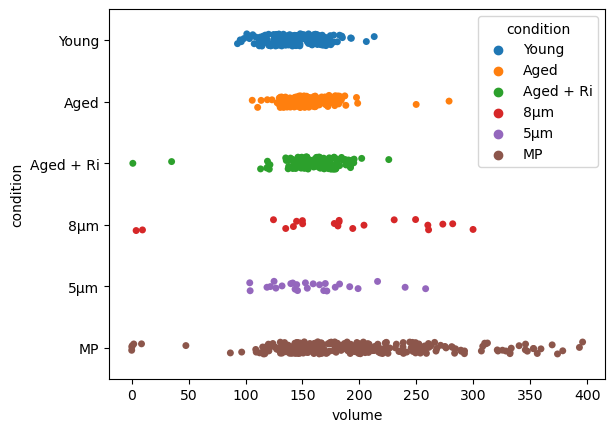

In [11]:
sns.stripplot(
    data=nuc_df,
    x="volume",
    y="condition",
    hue="condition",
    dodge=False,
    zorder=1,
)

In [12]:
nuc_df.columns

Index(['equivalent_diameter', 'feret_diameter_max', 'bbox-0', 'bbox-1',
       'bbox-2', 'bbox-3', 'bbox-4', 'bbox-5', 'centroid-0', 'centroid-1',
       'centroid-2', 'major_axis_length', 'minor_axis_length',
       'mean_intensity', 'min_intensity', 'max_intensity', 'label', 'solidity',
       'volume', 'bbox_volume', 'convex_volume', 'filled_volume', 'width',
       'length', 'height', 'height_deviation', 'elongation', 'aspect_ratio',
       'invagination_prop', 'surface_area', 'sphericity', 'surface/volume',
       'int_0.0-0.5', 'int_1.0-1.5', 'int_ratio', '2D_slide_area',
       '2D_slide_bbox-0', '2D_slide_bbox-1', '2D_slide_bbox-2',
       '2D_slide_bbox-3', '2D_slide_centroid-0', '2D_slide_centroid-1',
       '2D_slide_eccentricity', '2D_slide_major_axis_length',
       '2D_slide_minor_axis_length', '2D_slide_perimeter',
       '2D_slide_perimeter_crofton', '2D_slide_equivalent_diameter',
       '2D_slide_feret_diameter_max', '2D_slide_roundness',
       '2D_slide_compactness'

<Axes: xlabel='2D_slide_EOP', ylabel='condition'>

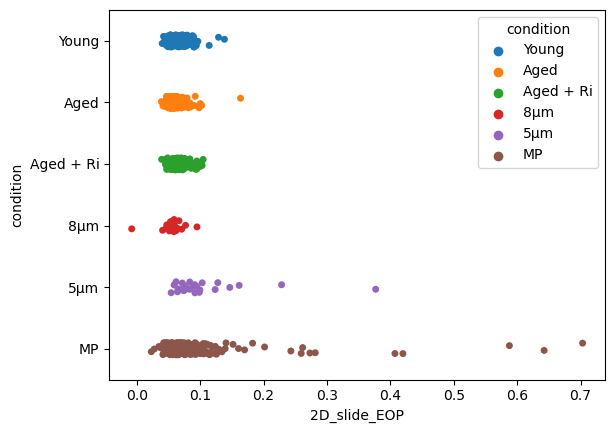

In [13]:
sns.stripplot(
    data=nuc_df,
    x="2D_slide_EOP",
    y="condition",
    hue="condition",
    dodge=False,
    zorder=1,
)

In [14]:
# Identify the "splashed cells" that occupy the whole image grid
nuc_df.query("volume > 400")

,equivalent_diameter,feret_diameter_max,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,centroid-0,centroid-1,...,DIRs_n,DIRs_centroid_distance2border,DIRs_mean_distance2border,DIRs_min_distance2border,res_Z,sigma_noise,im_path,im_batch,im_nuc,condition


In [15]:
# Remove artifacts created by the segmentation which are too small to be nuclei
# these are exactly the images that were not standardized properly
nuc_df.query("volume < 40").im_path.unique()

array(['3D_res=0.1_norm=z_score_npz/aged_treated_RhoAi/20201218expSlide9A1+RiTazCy3_nuc_43.npz',
       '3D_res=0.1_norm=z_score_npz/aged_treated_RhoAi/20201218expAg1+RiH3K9me2_2_nuc_33.npz',
       '3D_res=0.1_norm=z_score_npz/young_compressed_8um/20220527exp_20220615_8umRhoGTPTAZ_nuc_2_8um.npz',
       '3D_res=0.1_norm=z_score_npz/young_compressed_8um/20220530exp_20220615_8umRhoGTPTAZlooks like 8_nuc_62_8um.npz',
       '3D_res=0.1_norm=z_score_npz/myeloid_progenitors/20210916_KDM3A_2_nuc_118.npz',
       '3D_res=0.1_norm=z_score_npz/myeloid_progenitors/20210916_KDM3A_2_nuc_114.npz',
       '3D_res=0.1_norm=z_score_npz/myeloid_progenitors/20211203_KDM3A_nuc_86.npz',
       '3D_res=0.1_norm=z_score_npz/myeloid_progenitors/20210122_PHF8-NewAB_nuc_50.npz',
       '3D_res=0.1_norm=z_score_npz/myeloid_progenitors/20210916_KDM3A_2_nuc_113.npz'],
      dtype=object)

In [16]:
# Three of these are also images with volume > 400
nuc_df.query("DIRs_volume > 5").im_path.unique()

array(['3D_res=0.1_norm=z_score_npz/young_compressed_8um/20220527exp_20220615_8umRhoGTPTAZ_nuc_1_8um.npz',
       '3D_res=0.1_norm=z_score_npz/young_compressed_5um/20220510exp_220519_conf4.8_2_nuc_13_5um.npz',
       '3D_res=0.1_norm=z_score_npz/young_compressed_5um/20220510exp_220519_conf4.8_2_nuc_15_5um.npz',
       '3D_res=0.1_norm=z_score_npz/myeloid_progenitors/20210120_PHF8-OldAB_nuc_60.npz',
       '3D_res=0.1_norm=z_score_npz/myeloid_progenitors/20210120_PHF8-OldAB_nuc_25.npz'],
      dtype=object)

In [17]:
nuc_df.query("`2D_slide_EOP` > 0.25").im_path.unique()

array(['3D_res=0.1_norm=z_score_npz/young_compressed_5um/20220525exp_20220610_RhoGTPTAZ_B_5um_nuc_48_5um.npz',
       '3D_res=0.1_norm=z_score_npz/myeloid_progenitors/20210121_PHF8-NewAB_nuc_43.npz',
       '3D_res=0.1_norm=z_score_npz/myeloid_progenitors/20210120_PHF8-OldAB_nuc_57.npz',
       '3D_res=0.1_norm=z_score_npz/myeloid_progenitors/20210120_PHF8-OldAB_nuc_53.npz',
       '3D_res=0.1_norm=z_score_npz/myeloid_progenitors/20210122_PHF8-NewAB_nuc_52.npz',
       '3D_res=0.1_norm=z_score_npz/myeloid_progenitors/20210114_KDM4B_nuc_15.npz',
       '3D_res=0.1_norm=z_score_npz/myeloid_progenitors/20210120_PHF8-OldAB_nuc_65.npz',
       '3D_res=0.1_norm=z_score_npz/myeloid_progenitors/20210114_KDM4B_nuc_20.npz',
       '3D_res=0.1_norm=z_score_npz/myeloid_progenitors/20210126_KDM4A_nuc_46.npz',
       '3D_res=0.1_norm=z_score_npz/myeloid_progenitors/20210120_PHF8-OldAB_nuc_25.npz'],
      dtype=object)

In [18]:
bad_imgs = nuc_df.query("`2D_slide_EOP` > 0.25").im_path.unique()
bad_imgs = "../data/preprocessed/3" + bad_imgs
bad_imgs

array(['../data/preprocessed/33D_res=0.1_norm=z_score_npz/young_compressed_5um/20220525exp_20220610_RhoGTPTAZ_B_5um_nuc_48_5um.npz',
       '../data/preprocessed/33D_res=0.1_norm=z_score_npz/myeloid_progenitors/20210121_PHF8-NewAB_nuc_43.npz',
       '../data/preprocessed/33D_res=0.1_norm=z_score_npz/myeloid_progenitors/20210120_PHF8-OldAB_nuc_57.npz',
       '../data/preprocessed/33D_res=0.1_norm=z_score_npz/myeloid_progenitors/20210120_PHF8-OldAB_nuc_53.npz',
       '../data/preprocessed/33D_res=0.1_norm=z_score_npz/myeloid_progenitors/20210122_PHF8-NewAB_nuc_52.npz',
       '../data/preprocessed/33D_res=0.1_norm=z_score_npz/myeloid_progenitors/20210114_KDM4B_nuc_15.npz',
       '../data/preprocessed/33D_res=0.1_norm=z_score_npz/myeloid_progenitors/20210120_PHF8-OldAB_nuc_65.npz',
       '../data/preprocessed/33D_res=0.1_norm=z_score_npz/myeloid_progenitors/20210114_KDM4B_nuc_20.npz',
       '../data/preprocessed/33D_res=0.1_norm=z_score_npz/myeloid_progenitors/20210126_KDM4A_nuc_46.

In [19]:
# nuc_df = nuc_df.query(
#    "volume > 40 and DIRs_volume < 5 and mean_intensity < 0.001 and mean_intensity > -0.001"
# )
nuc_df = nuc_df.query(
    "volume > 40  and DIRs_volume < 5 and `2D_slide_EOP` < 0.25"
)

In [20]:
nuc_df.shape

(780, 92)

In [21]:
# Save the pandas dataframe as a csv file
nuc_df.to_csv(f"results/{norm}_nuclei_3d_res{res}_cf{cft}_filt_df.csv")